### Figure 2: Cell Turnover, Anisomycin Effects, and Placefield Stability Remapping

Note that you must run through `run_placefields.py` for each mouse to check day-to-day alignment of behavioral data before running most of the place field related functions below.

In [188]:
import scipy.stats as sstats
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import pingouin as pg

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror, fix_xlabels
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import cell_tracking as ct
import er_plot_functions as erp
from helpers import flatten
from subjects import load_df

plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up plots

In [159]:
Fig2comb, FigS4comb, FigS4bcomb, FigS4ccomb, Fig2insetcomb = None, None, None, None, None

[6.375 4.875]


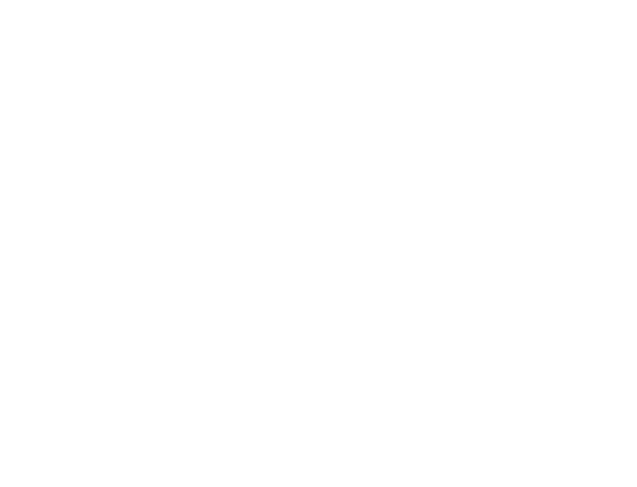

In [160]:
# Set up main figure plotting
%matplotlib ipympl
Fig2 = Fig(num=2, grid=(4, 4), size=(6.375, 4.875), fontsize=6)
print(Fig2.fig.get_size_inches())

[6.375 4.875]


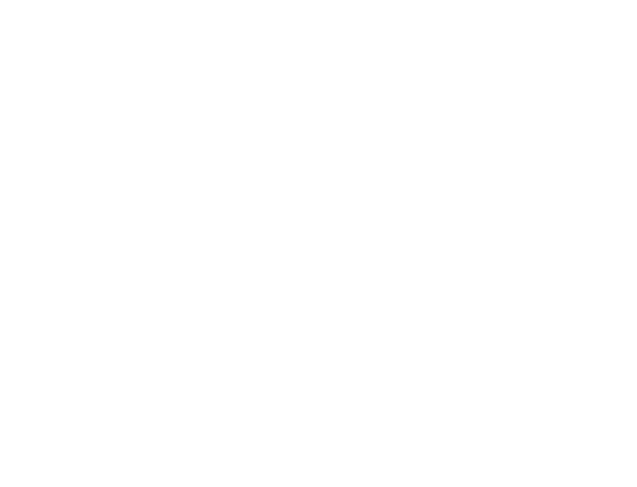

In [161]:
# Set up stats figure
Fig2stats = Fig(num="Figure 2 stats", grid=(4, 4), size=(6.375, 4.875), fontsize=6)
print(Fig2.fig.get_size_inches())
Fig2comb = FigMirror(Fig2, Fig2stats)

[6.375 4.875]


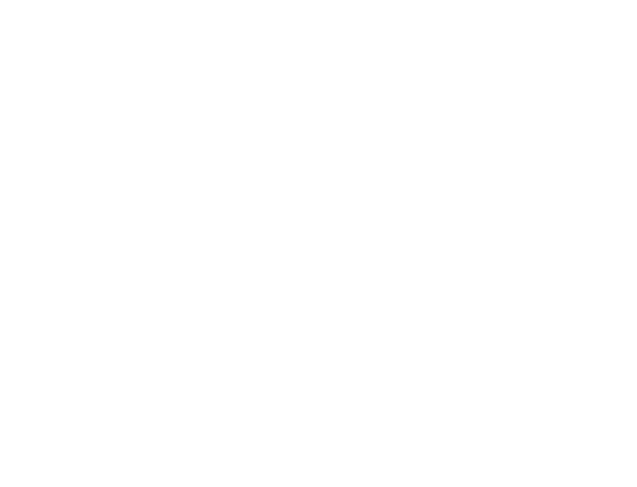

In [162]:
# Set up supplemental fig + stats
FigS4 = Fig(num="Figure S4", grid=(4, 4), size=(6.375, 4.875), fontsize=6)
print(FigS4.fig.get_size_inches())

[6.375 4.875]


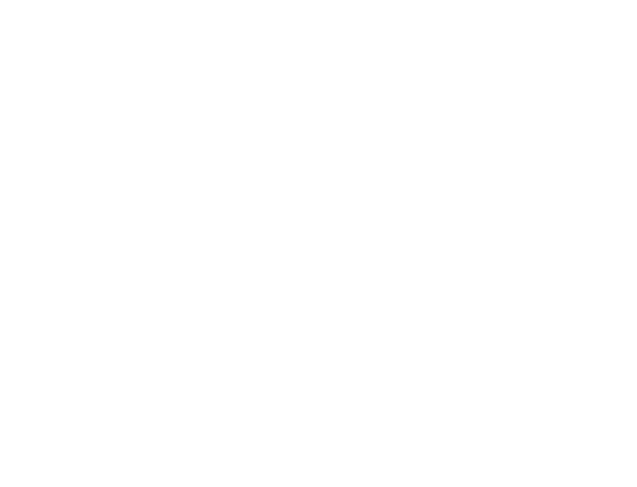

In [163]:
FigS4stats = Fig(num="Figure S4 stats", grid=(4, 4), size=(6.375, 4.875), fontsize=6)
print(FigS4stats.fig.get_size_inches())
FigS4comb = FigMirror(FigS4, FigS4stats)

In [202]:
%matplotlib ipympl
Figncells = Fig(num="ncells", grid=(4, 4), size=(6.375, 3.875), fontsize=6)
print(Figncells.fig.get_size_inches())

[6.375 3.875]


### Absolute # cells each day

In [11]:
n_df = []
arenas = ["Open", "Shock"]
days = [-2, -1, 0, 4, 1, 2, 7]
n = 0
for grp, mice in zip(["Learners", "Non-Learners", "ANI"], [err.learners, err.nonlearners, err.ani_mice_good]):
    for mouse in mice:
        for arena in arenas:
            arena_name = "Neutral" if arena == "Open" else "Shock"
            for day in days:
                try:
                    pftemp = pf.load_pf(mouse, arena, day)
                    if (arena == "Shock") & (day == 0):
                        pass
                    else:
                        n_df.append(pd.DataFrame({"Group": grp, "Mouse": mouse, "Arena": arena_name, "Day": day, "# neurons": pftemp.nneurons},
                                                 index=[n]))
                        n += 1
                except FileNotFoundError:
                    pass
                    
n_df = pd.concat(n_df, axis=0)             

In [41]:
get_exp_grp = lambda row : "Ctrl" if row["Group"] in ["Learners", "Non-Learners"] else "ANI"
get_day_str = lambda row : f"Day {row['Day']}" if row["Day"] != 4 else "4 Hour"
n_df["Exp. Group"] = n_df.apply(get_exp_grp, axis=1)
n_df["Session"] = n_df.apply(get_day_str, axis=1)
n_df["Session"] = pd.Categorical(n_df["Session"], ["Day -2", "Day -1", "Day 0", "4 Hour", "Day 1", "Day 2", "Day 7"])

In [137]:
def offset_lineplot(ax, offset=0.2):
    line_inds = np.where([isinstance(child, mpl.lines.Line2D) for child in ax.get_children()])[0]
    for lid in line_inds:
        line_adj = ax.get_children()[lid]
        offset_add = offset * -1 if line_adj.get_color() == sns.color_palette()[0] else offset
        if isinstance(line_adj.get_data()[0], np.ndarray):
            x_adj = line_adj.get_data()[0] + offset_add
            line_adj.set_data((x_adj, line_adj.get_data()[1]))

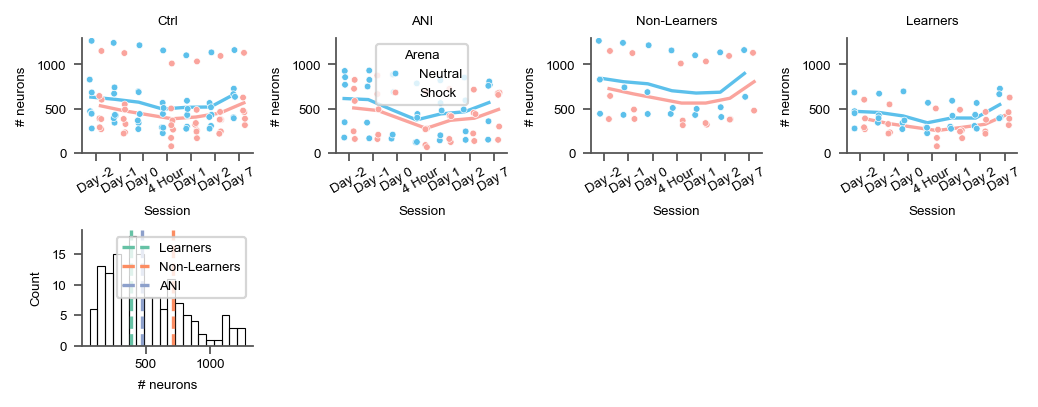

In [203]:
# fig, ax = plt.subplots(3, 2, figsize=(5, 6), tight_layout=True)


# Plot ANI vs Ctrl
for ida, exp_grp in enumerate(["Ctrl", "ANI"]):
    a = Figncells.subplot((4, 4, ida + 1))
    df_exp_grp = n_df[n_df["Exp. Group"] == exp_grp]
    legend = True if exp_grp == "ANI" else False
    sns.stripplot(data=df_exp_grp, x="Session", y="# neurons", hue="Arena", dodge=True, ax=a, edgecolor="w",
                  linewidth=0.3, size=3, legend=legend)
    sns.lineplot(data=df_exp_grp, x="Session", y="# neurons", hue="Arena", errorbar=None, ax=a, legend=False)
    a.set_ylim([0, 1300])
    a.tick_params(axis="x", labelrotation=30)
    offset_lineplot(a)
    a.set_title(exp_grp)
sns.despine(fig=fig)

# Plot Learners v Non-Learners
for ida, exp_grp in enumerate(["Non-Learners", "Learners"]):
    a = Figncells.subplot((4, 4, ida + 3))
    df_exp_grp = n_df[n_df["Group"] == exp_grp]
    legend = True
    pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
    pal_use = pal_use[0:2] if exp_grp == "Ctrl" else [pal_use[2]]
    sns.stripplot(data=df_exp_grp, x="Session", y="# neurons", hue="Arena", dodge=True, ax=a, edgecolor="w",
                  linewidth=0.3, size=3, legend=False)
    sns.lineplot(data=df_exp_grp, x="Session", y="# neurons", hue="Arena", errorbar=None, ax=a, legend=False)
    a.set_ylim([0, 1300])
    a.tick_params(axis="x", labelrotation=30)
    a.set_title(exp_grp)
    offset_lineplot(a)
sns.despine(fig=fig)

# Plot histogram of all cell counts with mean for each group overlaid
a = Figncells.subplot((4, 4, 5))
sns.histplot(data=n_df, x="# neurons", fill=False, color='k', bins=20, ax=a)
mean_df = n_df.groupby(["Group"]).mean(numeric_only=True)
hlcomb = []
for color, grp in zip(plt.get_cmap("Set2").colors, ["Learners", "Non-Learners", "ANI"]):
    hl = a.axvline(mean_df.loc[grp, "# neurons"], color=color, linestyle='--')
    hlcomb.append(hl)
a.legend(hlcomb, ["Learners", "Non-Learners", "ANI"])

Figncells.savefig(plot_path / "n_cells_absolute.pdf")
Figncells.fig

In [95]:
def offset_lineplot(ax, offset=0.2):
    line_inds = np.where([isinstance(child, mpl.lines.Line2D) for child in ax.get_children()])[0]
    for lid in line_inds:
        line_adj = ax.get_children()[lid]
        offset_add = offset * -1 if line_adj.get_color() == sns.color_palette()[0] else offset
        print(offset_add)
        x_adj = line_adj.get_data()[0] + offset_add
        line_adj.set_data((x_adj, line_adj.get_data()[1]))

### Fig 2A-B: Cell turnover across days

In [164]:
# Test code for reshaping - want 1st index from 3rd dim folded into 2nd, e.g. combine shock v shock and open v open
# Not currently used, but could be useful if we need to add in "open" v "open" overlaps at some later point, no
# currently included, only "shock" v "shock"
a = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
a[:, :, 1] = a[:, :, 1]*10
print(a)
# So 1, 4, 7, and 20, 50, 80 are same arena, 3, 6, 9 are different
b = np.append(a, np.nan*np.ones_like(a[:, :, 2, None]), axis=2)
c = b.reshape((int(b.shape[0]*2), b.shape[1], int(b.shape[2]/2)), order='F')
print('3rd dim index = 0 after reshaping - should be 1, 4, 7, 20, 50, 80')
print(c[:, :, 0])
print('3rd dim index = 1 after reshaping - should be 3, 6, 9, and nan')
print(c[:, :, 1])
# Ok, so this works - things are grouped appropriately

[[[ 1 20  3]
  [ 4 50  6]
  [ 7 80  9]]

 [[ 1 20  3]
  [ 4 50  6]
  [ 7 80  9]]]
3rd dim index = 0 after reshaping - should be 1, 4, 7, 20, 50, 80
[[ 1.  7. 50.]
 [ 1.  7. 50.]
 [ 4. 20. 80.]
 [ 4. 20. 80.]]
3rd dim index = 1 after reshaping - should be 3, 6, 9, and nan
[[ 3.  9. nan]
 [ 3.  9. nan]
 [ 6. nan nan]
 [ 6. nan nan]]


0.2985781990521327


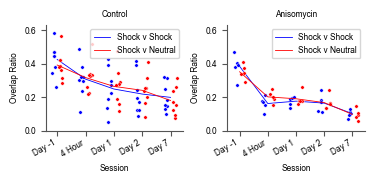

In [165]:
plot_ind = False
ylims = (0, 0.63)

axolap_ctrl = Fig2.subplot(441)
axolap_ani = Fig2.subplot(442)

oratioboth_comb = []
base_day = -2
for ax, mice, group_title in zip([axolap_ctrl, axolap_ani], [err.control_mice_good, err.ani_mice_good], 
                                 ["Control", "Anisomycin"]):
    # days = [-1, 0, 4, 1, 2]  # use this to look at change from day 0 to 4hr sesh (good in control arena only)
    days = [-1, 4, 1, 2, 7]  # legit way - use to look at change across all days with 10 min sessions
    arenas = [["Shock", "Shock"], ["Shock", "Open"]]
    oratio1 = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratio2 = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratioboth = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratiomin = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratiomax = np.ones((len(mice), len(days), len(arenas)))*np.nan

    # Get overlapping cell ratios for each day/arena using Shock day -2 as a reference
    pathname = err.pathname  # Get plotting folder
    for idm, mouse in enumerate(mice):
        for idd, day in enumerate(days):
            for ida, arena_pair in enumerate(arenas):
                try:
                    _, _, oratioboth[idm, idd, ida], oratiomin[idm, idd, ida], oratiomax[idm, idd, ida] = \
                        pfs.get_overlap(mouse, arena_pair[0], base_day, arena_pair[1], day)
                    if (mouse == "Marble14") and (arena_pair[1] == "Shock") and (day == 4):
                        _, _, a, _, _ = \
                        pfs.get_overlap(mouse, arena_pair[0], base_day, arena_pair[1], day)
                        print(a)
                except TypeError:
                    print('Missing reg file for ' + mouse + ' Day ' + str(day) + ' ' + arena)

        if plot_ind:
            fig, ax, hline = er.plot_overlaps(oratio1[idm, :, :], days=days, size=4, linewidth=0.2, edgecolor='w')
            fig.savefig(os.path.join(pathname, 'Cell Overlap ' + group_title + '-' + mouse + '.pdf'))
            plt.close(fig)
    
    _, _ = er.plot_overlaps(oratioboth, days=days, jitter=[-0.09, 0.09], colors = ['b', 'r'], offset=(-0.14, 0.14),
                            arenas=['Shock v Shock', 'Shock v Neutral'], ax=ax, markersize=2.5,
                            meanlinewidth=0.6, markeredgecolor='w', markeredgewidth=0.3)
    ax.set_title(group_title)
    ax.set_ylabel('Overlap Ratio')
    ax.set_ylim(ylims)
    fix_xlabels(ax, rotate=True)

    oratioboth_comb.append(oratioboth)  # Create list with both groups data in it
Fig2.fig

#### Per KD analysis suggestion make the above plot but use 4 hour session as baseline. Not informative

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_99306/1496996512.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig4, ax4 = plt.subplots(1, 2, figsize=(6, 3), sharey=True)


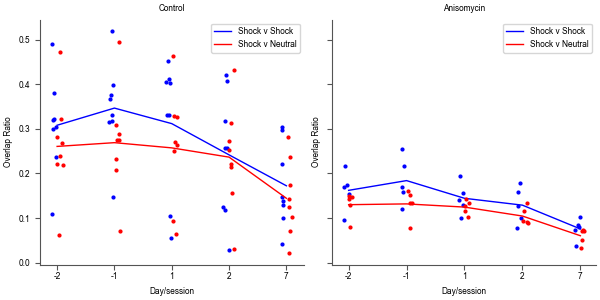

In [197]:
plot_ind = False

fig4, ax4 = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
axolap4_ctrl = ax4[0]
axolap4_ani = ax4[1]

oratioboth_comb = []
base_day = 4
# days = [-1, 0, 4, 1, 2]  # use this to look at change from day 0 to 4hr sesh (good in control arena only)
days = [-2, -1, 1, 2, 7]  # legit way - use to look at change across all days with 10 min sessions
for ax, mice, group_title in zip([axolap4_ctrl, axolap4_ani], [err.control_mice_good, err.ani_mice_good], 
                                 ["Control", "Anisomycin"]):
    days_use = [day for day in days if day != base_day]
    arenas = [["Shock", "Shock"], ["Shock", "Open"]]
    oratio1 = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratio2 = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratioboth = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratiomin = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratiomax = np.ones((len(mice), len(days), len(arenas)))*np.nan

    # Get overlapping cell ratios for each day/arena using Shock day -2 as a reference
    pathname = err.pathname  # Get plotting folder
    for idm, mouse in enumerate(mice):
        for idd, day in enumerate(days_use):
            for ida, arena_pair in enumerate(arenas):
                try:
                    _, _, oratioboth[idm, idd, ida], oratiomin[idm, idd, ida], oratiomax[idm, idd, ida] = \
                        pfs.get_overlap(mouse, arena_pair[0], base_day, arena_pair[1], day)
                except TypeError:
                    print('Missing reg file for ' + mouse + ' Day ' + str(day) + ' ' + arena)

        if plot_ind:
            fig, ax, hline = er.plot_overlaps(oratio1[idm, :, :], days=days)
            fig.savefig(os.path.join(pathname, 'Cell Overlap ' + group_title + '-' + mouse + '.pdf'))
            plt.close(fig)
    
    _, _ = er.plot_overlaps(oratioboth, days=days, jitter=[-0.05, 0.05], colors = ['b', 'r'], 
                              arenas=['Shock v Shock', 'Shock v Neutral'], ax=ax, markersize=2.0)
    ax.set_title(group_title)
    ax.set_ylabel('Overlap Ratio')

    oratioboth_comb.append(oratioboth)  # Create list with both groups data in it.

placefields_cm1_manlims_1000shuf.pkl not found, loading FinalOutput.mat which is slow
placefields_cm1_manlims_1000shuf.pkl not found, loading FinalOutput.mat which is slow
placefields_cm1_manlims_1000shuf.pkl not found, loading FinalOutput.mat which is slow
placefields_cm1_manlims_1000shuf.pkl not found, loading FinalOutput.mat which is slow
placefields_cm1_manlims_1000shuf.pkl not found, loading FinalOutput.mat which is slow
placefields_cm1_manlims_1000shuf.pkl not found, loading FinalOutput.mat which is slow


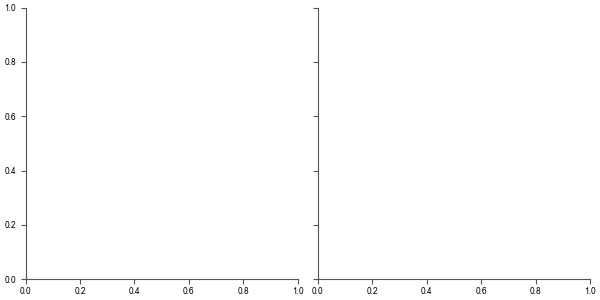

In [193]:
plot_ind = False

oratioboth_comb = []
base_day = 0
# days = [-1, 0, 4, 1, 2]  # use this to look at change from day 0 to 4hr sesh (good in control arena only)
days = [-2, -1, 4, 1, 2, 7]  # legit way - use to look at change across all days with 10 min sessions
df_list = []
for mice, group_title in zip([err.control_mice_good, err.ani_mice_good],  ["Control", "Anisomycin"]):
    days_use = [day for day in days if day != base_day]
    arenas = [["Open", "Open"]]
    oratio1 = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratio2 = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratioboth = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratiomin = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratiomax = np.ones((len(mice), len(days), len(arenas)))*np.nan

    # Get overlapping cell ratios for each day/arena using Shock day -2 as a reference
    pathname = err.pathname  # Get plotting folder
    mouse_list, day_list, arena_list, oratio_list = [], [], [], []
    for idm, mouse in enumerate(mice):
        for idd, day in enumerate(days_use):
            for ida, arena_pair in enumerate(arenas):
                try:
                    _, _, oratioboth[idm, idd, ida], oratiomin[idm, idd, ida], oratiomax[idm, idd, ida] = \
                        pfs.get_overlap(mouse, arena_pair[0], base_day, arena_pair[1], day)
                    mouse_list.append(mouse)
                    day_list.append(day)
                    arena_list.append(" v ".join(arena_pair))
                    oratio_list.append(oratioboth[idm, idd, ida])
                    
                except TypeError:
                    print('Missing reg file for ' + mouse + ' Day ' + str(day) + ' ' + arena)

    oratioboth_comb.append(oratioboth)  # Create list with both groups data in it.
    
    df_list.append(pd.DataFrame({"Group": group_title, "Mouse": mouse_list, "Day": day_list, 
                                 "Arena pair": arena_list, "Overlap Ratio": oratio_list}))
olap0_df = pd.concat(df_list, axis=0).reset_index()
olap0_df["Day"] = pd.Categorical(olap0_df["Day"], days)

In [209]:
def get_day_ind(row, day_list):
    
    return np.where(row.Day == np.array(day_list))[0][0]
day_list = [-2, -1, 4, 1, 2, 7]
olap0_df.head(6).apply(lambda row : get_day_ind(row, day_list), axis=1)

0    0
1    1
2    2
3    3
4    4
5    5
dtype: int64

In [204]:
ax0[0].get_xticks()

[0, 1, 2, 3, 4, 5]

In [215]:
ax0[0].get_children()

 Text(0.5, 1.0, ''),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

<Axes: xlabel='Day', ylabel='Overlap Ratio'>

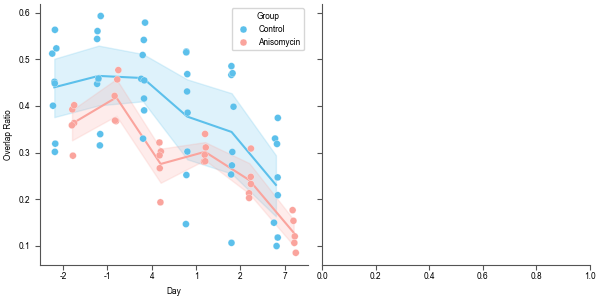

In [216]:
fig0, ax0 = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
axolap0_ctrl = ax0[0]
axolap0_ani = ax0[1]

sns.stripplot(data=olap0_df, x="Day", y="Overlap Ratio", hue="Group", dodge=True, ax=ax0[0],
             edgecolor="w", linewidth=0.2)

offset = 0.2
olap0_df["Day Ind"] = olap0_df.apply(lambda row : get_day_ind(row, day_list), axis=1)
olap0_df["Day Ind"] = olap0_df.apply(lambda row : row["Day Ind"] - offset if row["Group"] == "Control" else row["Day Ind"] + offset, axis = 1 )
sns.lineplot(data=olap0_df, x="Day Ind", y="Overlap Ratio", hue="Group", ax=ax0[0], legend=False)
# for ax, group_title in zip([axolap0_ctrl, axolap0_ani], ["Control", "Anisomycin"]):
#     df_use = olap0_df[olap0_df["Group"] == group_title]
#     sns.stripplot(data=df_use, x="Day", y="Overlap Ratio", ax=ax)
#     ax.set_title(group_title)
#     ax.set_ylabel('Overlap Ratio')


### 2C Now quantify accelerated change and then slower change (measured by cell overlap) due to ANI administration

In [ ]:
# Dump data into dataframe for easy plotting in seaborn afterward...
day_pairs = ['-1_4', '4_1', '1_2', '2_7']
grp_list, dolap_list, day_list = [], [], []
grp_mean_list, dolap_mean_list, day_mean_list = [], [], []
for idg, grp in enumerate(['Ctrl', 'ANI']):
    oratio_use = oratioboth_comb[idg]
    for idd, day_pair in enumerate(day_pairs):
        dolap = oratio_use[:, idd, :].reshape(-1) - oratio_use[:, idd + 1, :].reshape(-1)
        dolap_list.extend(dolap)
        grp_list.extend(len(dolap)*[grp])
        day_list.extend(len(dolap)*[day_pair])

        dolap_mean = (oratio_use[:, idd, :] - oratio_use[:, idd + 1, :]).mean(axis=1)
        dolap_mean_list.extend(dolap_mean)
        grp_mean_list.extend(len(dolap_mean)*[grp])
        day_mean_list.extend(len(dolap_mean)*[day_pair])

dolap_df = pd.DataFrame({'day_pair': day_list, 'dolap': dolap_list, 'Group': grp_list})
dolap_mean_df = pd.DataFrame({'day_pair': day_mean_list, 'dolap': dolap_mean_list, 'Group': grp_mean_list})

In [ ]:
### Plot means
axolap_bw, axolap_bw_stats = Fig2comb.subplot(443)
# Adjust pallete to match color scheme in other plots
pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
pal_use.pop(0)
pal_use = pal_use[0:2]
hdolap = sns.stripplot(data=dolap_mean_df, x='day_pair', y='dolap', hue='Group', dodge=True, palette=pal_use, 
                       ax=axolap_bw, size=2.5, linewidth=0.3, edgecolor='w', jitter=0.15)
# Fix legend markers
for h1 in hdolap.legend().legend_handles:
    h1._sizes = [3]
axolap_bw.set_ylabel(r'$\Delta_{overlap}$')
axolap_bw.set_xticklabels([' to '.join(day_pair.split('_')) for day_pair in day_pairs])
axolap_bw.set_xlabel('Day Pair')

In [ ]:
ytext = 0.7
axolap_bw_stats.text(0.1, 0.8, r'Delta overlap bw groups stats}')
for day_pair in set(dolap_mean_df['day_pair']):
    ctrl = dolap_mean_df[(dolap_mean_df['Group'] == 'Ctrl') & (dolap_mean_df['day_pair'] == day_pair)]['dolap']
    ani = dolap_mean_df[(dolap_mean_df['Group'] == 'ANI') & (dolap_mean_df['day_pair'] == day_pair)]['dolap']
    tstat, pval = sstats.ttest_ind(ctrl, ani, nan_policy='omit', alternative="two-sided")
    print(f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    axolap_bw_stats.text(0.1, ytext, f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    ytext -= 0.1

In [ ]:
# Plot all data points individually for reference
_, ax = plt.subplots(1, 2, figsize=(6, 3))

# Adjust pallete to match color scheme in other plots
pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
pal_use.pop(0)
pal_use = pal_use[0:2]
hdolap = sns.stripplot(data=dolap_df, x='day_pair', y='dolap', hue='Group', dodge=True, palette=pal_use, 
                       ax=ax[0], size=3.5, linewidth=0.2, edgecolor='w', jitter=0.15)
# Fix legend markers
for h1 in hdolap.legend().legend_handles:
    h1._sizes = [3]
ax[0].set_ylabel(r'$\Delta_{overlap}$')
ax[0].set_xticklabels([' to '.join(day_pair.split('_')) for day_pair in day_pairs])
ax[0].set_xlabel('Day Pair')

In [ ]:
ytext = 0.7
ax[1].text(0.1, 0.8, r'Delta overlap bw groups stats}')
for day_pair in set(dolap_df['day_pair']):
    ctrl = dolap_df[(dolap_df['Group'] == 'Ctrl') & (dolap_df['day_pair'] == day_pair)]['dolap']
    ani = dolap_df[(dolap_df['Group'] == 'ANI') & (dolap_df['day_pair'] == day_pair)]['dolap']
    tstat, pval = sstats.ttest_ind(ctrl, ani, nan_policy='omit')
    print(f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    ax[1].text(0.1, ytext, f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    ytext -= 0.1

### 2D Plot Number of Neurons active for each session

In [ ]:
def nneurons_to_df(nneurons, arenas, days, mice, gname, norm_sesh_ind=0):
    """Put nneurons array into a dataframe for easy statistical analysis"""
    nmice, narenas, ndays = nneurons.shape
    assert nmice == len(mice)
    assert narenas == len(arenas)
    assert ndays == len(days)
    
    mouse_mat = np.matlib.repmat(mice, ndays, 1).T
    days_mat = np.matlib.repmat(days, nmice, 1)
    cond = []
    for day in days:
        if day in [-2, -1]:
            cond.append('Before')
        elif day == 4:
            cond.append('During')
        elif day in [1, 2, 7]:
            cond.append('After')
    cond_mat = np.matlib.repmat(cond, nmice, 1)
    df_list = []
    for ida, arena in enumerate(arenas):
        arena_mat = np.matlib.repmat([arena,]*ndays, nmice, 1)
        nneurons_norm = None
        if norm_sesh_ind is not None:
            nneurons_norm = ct.norm_num_neurons(nneurons[:, ida, :][:, None, :], norm_sesh_ind)
        df_list.append(pd.DataFrame({"nneurons" : nneurons[:, ida, :].reshape(-1), "nneurons_norm" : nneurons_norm.reshape(-1),
                                     "arena" : arena_mat.reshape(-1), "mouse" : mouse_mat.reshape(-1), 
                                     "day" : days_mat.reshape(-1), "condition" : cond_mat.reshape(-1), "Group" : (gname,)*cond_mat.size}))

    return pd.concat(df_list)

days = [-2, -1, 4, 1, 2, 7]
arenas = ['Shock', 'Open']
mice = err.ani_mice_good
nneurons = ct.get_group_num_neurons(mice, days=days, arenas=arenas)
nneurons_to_df(nneurons, arenas, days, mice, "ANI", 1).head(10)                               
        

In [ ]:
# Aggregate #neurons and plot each

days = [-2, -1, 4, 1, 2, 7]
norm_sesh_ind = [0, 1] # index of session from days array to normalize to

arenas = ['Shock', 'Open']
nneurons_comb, nneurons_mean_comb, nneurons_open_comb, nneurons_shock_comb = [], [], [], []
df_list, df_mean_list = [], []
for mice, grp in zip([err.control_mice_good, err.ani_mice_good], ["Control", "ANI"]):

    # # Get overlapping cell ratios for each day/arena using Shock day -2 as a reference
    nneurons = ct.get_group_num_neurons(mice, days=days, arenas=arenas)
    df_list.append(nneurons_to_df(nneurons, arenas, days, mice, grp, norm_sesh_ind))
    df_mean_list.append(nneurons_to_df(nneurons.mean(axis=1)[:, None, :], ['Combined'], days, mice, grp, norm_sesh_ind))
    nanimals = nneurons.shape[0]
    nneurons_comb.append(nneurons.reshape(int(2*nanimals), 1, len(days)))  # Combine both areas for each mouse
    nneurons_mean_comb.append(nneurons.mean(axis=1)[:, None, :])
    nneurons_shock_comb.append(nneurons[:, 0, :][:, None, :])
    nneurons_open_comb.append(nneurons[:, 1, :][:, None, :])

nneuron_df = pd.concat(df_list)
nneuron_mean_df = pd.concat(df_mean_list)

# Now plot - Total #s (un-normalized) plotted in supplemental
ax_nn_comb, ax_nn_comb_stats = Fig2comb.subplot(444)
_, ax_nn_mean_comb = plt.subplots(1, 3, figsize=(8, 3))
pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
pal_use.pop(0)
for nn, nn_mean, nn_shock, nn_open, color, offset in zip(nneurons_comb, nneurons_mean_comb, nneurons_shock_comb, nneurons_open_comb, 
                                                           pal_use[0:2], (-0.15, 0.15)):
    ct.plot_num_neurons(nn, arena1='Combined', arena2=None, normalize=['-2', '-1'], colors=[color], offset=offset, jitter=0.075,
                        markersize=2.5, ax=ax_nn_mean_comb[0], markeredgecolor='w', markeredgewidth=0.3, linewidth=0.6)
    ct.plot_num_neurons(nn_mean, arena1='Combined', arena2=None, normalize=['-2', '-1'], colors=[color], offset=offset, jitter=0.075,
                        markersize=2.5, ax=ax_nn_comb, markeredgecolor='w', markeredgewidth=0.3, linewidth=0.6)
    ct.plot_num_neurons(nn_shock, arena1='Combined', arena2=None, normalize=['-2', '-1'], colors=[color], offset=offset, jitter=0.075,
                        markersize=2.5, ax=ax_nn_mean_comb[1], markeredgecolor='w', markeredgewidth=0.3, linewidth=0.6)
    ct.plot_num_neurons(nn_open, arena1='Combined', arena2=None, normalize=['-2', '-1'], colors=[color], offset=offset, jitter=0.075,
                        markersize=2.5, ax=ax_nn_mean_comb[2], markeredgecolor='w', markeredgewidth=0.3, linewidth=0.6)
ax_nn_mean_comb[0].set_title('Both arenas Combined')
ax_nn_mean_comb[1].set_title('# Shock')
ax_nn_mean_comb[2].set_title('# Open')

fix_xlabels(ax_nn_comb, rotate=True)
Fig2.fig

In [ ]:
# Stats for mean # neurons
nneurons_norm = [ct.norm_num_neurons(nn, [0, 1]) for nn in nneurons_mean_comb]
ax_nn_comb_stats.text(0.1, 0.8, 'Between group norm. # neurons stats')
ytext = 0.7
for idd, day in enumerate(days):
    # Separate data points for each arena
    n_ctrl = nneurons_norm[0][:, :, idd].reshape(-1)
    n_ani = nneurons_norm[1][:, :, idd].reshape(-1)
    tstat, pval = sstats.ttest_ind(n_ctrl, n_ani)
    print(f'Session {day}: pval={pval:0.3g}, tstat={tstat:0.3g}')
    ax_nn_comb_stats.text(0.1, ytext, f'Session {day}: pval={pval:0.3g}, tstat={tstat:0.3g}')
    ytext -= 0.1
    

In [ ]:
# stats for all neurons combined
nneurons_norm = [ct.norm_num_neurons(nn, 0) for nn in nneurons_comb]
# ax_nn_comb_stats.text(0.1, 0.8, 'Between group norm. # neurons stats')
ytext = 0.7
for idd, day in enumerate(days):
    # Separate data points for each arena
    n_ctrl = nneurons_norm[0][:, :, idd].reshape(-1)
    n_ani = nneurons_norm[1][:, :, idd].reshape(-1)
    tstat, pval = sstats.ttest_ind(n_ctrl, n_ani)
    print(f'Session {day}: pval={pval:0.3g}, tstat={tstat:0.3g}')
    # ax_nn_comb_stats.text(0.1, ytext, f'Session {day}: pval={pval:0.3g}, tstat={tstat:0.3g}')
    ytext -= 0.1
    

Run GLM to ensure that other covariates, which could influence the number of cells recorded, don't explain the lack of significance found during the 4 hour session or on days 1, 2 or 7.
Factors:
1) Arena: locomotion is different on bars in shock arena vs. sold floor in open/neutral arena
2) Before/During/After anisomyin/fear conditioning: Before assesses baseline # cells, During tests acute effect of ANI/fear conditioning on cell #s, and After assesses if there are any lasting effects of ANI (or Trace FC) on cells
3) Group: ANI vs. Ctrl
4) Freeze Ratio: it is well established that the number of place cells correlates with how much the animals moves / explores an arena.  Need to account for differences in locomotion between groups.
5) Interactions between Group and Before/During/After: assess if ANI has a differential effect at each time point.

In [ ]:
import freezing_analysis as fa
def add_freezing(row, **kwargs):
    try:
        return fa.get_freeze_ratio(row['mouse'], row['arena'], row['day'], **kwargs)
    except FileNotFoundError:
        return np.nan

In [ ]:
# Add in freezing ratio to dataframe
from copy import copy, deepcopy
nneuron_df2 = deepcopy(nneuron_df)
nneuron_df2["freeze_ratio"] = nneuron_df2.apply(add_freezing, axis=1)

In [ ]:
import statsmodels.api as sm
nneuron_df3 = nneuron_df2[~np.isnan(nneuron_df2.freeze_ratio)]
# nneuron_df3 = nneuron_df3[nneuron_df3.day != -2]
endog = nneuron_df3.nneurons_norm.values
intercept = np.ones(nneuron_df3.shape[0])
arena_array = [0 if arena == "Shock" else 1 for arena in nneuron_df3.arena]
bef_array = nneuron_df3.condition == "Before"
dur_array = nneuron_df3.condition == "During"
aft_array = nneuron_df3.condition == "After"
group_array = nneuron_df3.Group == "ANI"
group_by_before = group_array & bef_array
group_by_during = group_array & dur_array
group_by_after = group_array & aft_array
freeze_array = nneuron_df3.freeze_ratio.values
exog = np.array([intercept, arena_array, dur_array, aft_array, group_array, group_by_during, group_by_after, freeze_array]).T
exog_df = pd.DataFrame(data=exog, columns = ["Int", "Arena", "During", "After", "Group", "Group x During", "Group x After", "Freeze Ratio"])
model = sm.GLM(endog, exog_df)
model_results = model.fit()
print(model_results.summary())

In [ ]:
model_results.pvalues

#### Plot #6: Plot of off cells by quartile - plotted separately by Dan Orlin in MATLAB
Not used

In [ ]:
# Put in placeholder
# ax_onoff = Fig2comb.subplot(445)
# ax_onoff[0].text(0.1, 0.5, 'Placeholder for DO on/off by quartile plot')

Plot #6a (Supplemental 1): Example max projections showing washout in ANI recordings - include with more raw data from other animals.

### 2E-F: Example place-fields across sessions  

Marble07, Shock Day -2 to Day -1 gives neuron #27 has a good example neuron. Grab a few others maybe? Example of remapping neuron?

In [ ]:
Fig2pf = Fig(num="Figure 2 PF examples", grid=(4, 4), size=(6.375, 4.875), fontsize=6)

In [ ]:
gs_pf_subfig = Fig2pf.subplot2grid(subplot_spec=Fig2pf.gs[2,0], grid=(2,2))
axp = []
for i in range(2):
    for j in range(2):
        axp.append(Fig2pf.fig.add_subplot(gs_pf_subfig[i, j]))
axp = np.array(axp).reshape(2,2)
PFS1 = pfs.PFCombineObject('Marble07', 'Shock', -2, 'Shock', -1)
nneuron = 27
PFS1.pfplot(nneuron, ax=axp, linewidth=0.5, markersize=1.0)

In [ ]:
gs_pf_subfig2 = Fig2pf.subplot2grid(subplot_spec=Fig2pf.gs[1,0], grid=(2,2))
axp2 = []
for i in range(2):
    for j in range(2):
        axp2.append(Fig2pf.fig.add_subplot(gs_pf_subfig2[i, j]))
axp2 = np.array(axp2).reshape(2,2)
PFS1 = pfs.PFCombineObject('Marble07', 'Shock', -2, 'Shock', 1)
nneuron = 64
PFS1.pfplot(nneuron, ax=axp2, linewidth=0.5, markersize=1.0)

### Plot #7a (Supplemental 2): Example place fields from Learner, Non-Learner, and ANI. 


In [156]:
FigPFexamples = Fig(num="Supp Fig PF examples", grid=(12, 6), size=(6.375, 14.875), fontsize=4, constrained_layout=True)
FigPFexamples.fig.get_layout_engine().set(w_pad=1 / 72, h_pad=1 / 72, hspace=0.02,
                            wspace=0)  # set spacing between grids to almost nothing!!

# Grab example cells for each group
# Learners: lower stability (more remapping) before v after in shock arena, stable otherwise
learner_dict = {"Marble12": {"Open": {"before": [3, 36], "before_after": [9, 29], 'after': [3, 12]}},
                "Marble07": {"Shock": {"before": [26, 28], "before_after": [26, 47], "after": [35, 70]}}}

# Non-Learners: lower stability (more remapping) before v after in neutral arean, stable otherwise
nlearner_dict = {"Marble29": {"Open": {"before": [12, 45], "before_after": [26, 37], 'after': [0, 20]}},
                "Marble11": {"Shock": {"before": [33, 62], "before_after": [2, 45], "after": [1, 17]}}}

# ANI: generally stable at all phases of the task
ani_dict = {"Marble19": {"Shock": {"before": [5, 35], "before_after": [18, 36], "after": [1, 28]}},
            "Marble20": {"Open": {"before": [0, 1], "before_after": [10, 19], "after": [2, 15]}}}
mouse_dict = learner_dict
mouse_dict.update(nlearner_dict)
mouse_dict.update(ani_dict)
# mouse_name, arena_dict = mouse_dict.items()
df_list = []
for mouse_name, arena_dict in mouse_dict.items():
    for arena_name, epoch_dict in arena_dict.items():
        for epoch_name, neurons in epoch_dict.items():
            df_list.append(pd.DataFrame({"mouse": mouse_name, "arena": arena_name, "epoch": epoch_name, "neuron": neurons}))

pf_df = pd.concat(df_list).reset_index()
pf_df

,index,mouse,arena,epoch,neuron
0,0,Marble12,Open,before,3
1,1,Marble12,Open,before,36
2,0,Marble12,Open,before_after,9
3,1,Marble12,Open,before_after,29
4,0,Marble12,Open,after,3
5,1,Marble12,Open,after,12
6,0,Marble07,Shock,before,26
7,1,Marble07,Shock,before,28
8,0,Marble07,Shock,before_after,26
9,1,Marble07,Shock,before_after,47


<Figure size 637.5x1487.5 with 0 Axes>

Loading previous 2d placefield analysis for Marble12 Open day -2 to Open day -1
Correlations calculated at best rotation angle = 90
Loading previous 2d placefield analysis for Marble12 Open day -2 to Open day -1
Loading previous 2d placefield analysis for Marble12 Open day -2 to Open day -1
Correlations calculated at best rotation angle = 90
Loading previous 2d placefield analysis for Marble12 Open day -2 to Open day -1
Loading previous 2d placefield analysis for Marble12 Open day -1 to Open day 1
Correlations calculated at best rotation angle = 180
Loading previous 2d placefield analysis for Marble12 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble12 Open day -1 to Open day 1
Correlations calculated at best rotation angle = 180
Loading previous 2d placefield analysis for Marble12 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble12 Open day 1 to Open day 2
Correlations calculated at best rotation angle = 180
Loading previous 2d pla

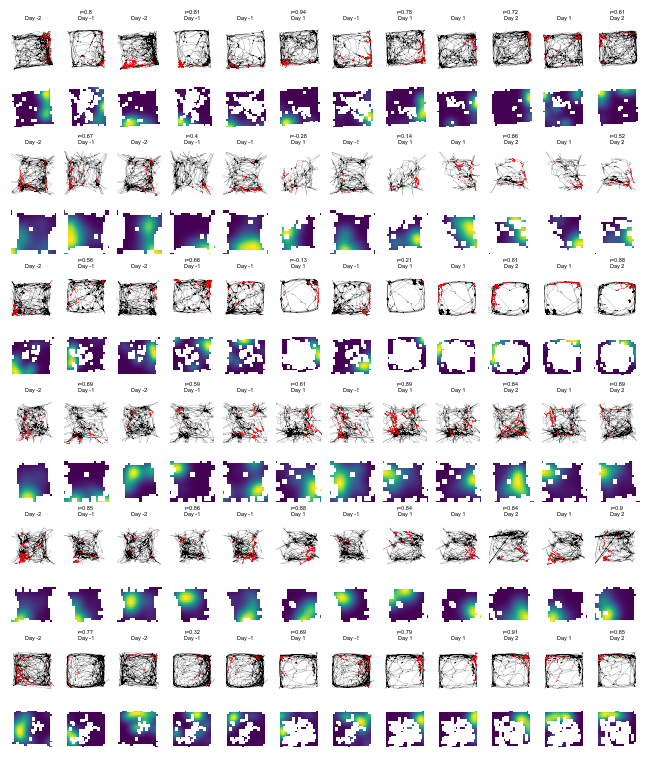

In [157]:
# Learner with high stability Before and After but remapping in shock = Marble12 extinction with remapping in shock arena
# Plot two cells from each epoch for 12 total?
day_lookup = {"before": [-2, -1], "before_after": [-1, 1], "after": [1, 2]}

for idm, mouse_name in enumerate(pf_df.mouse.unique()):
    df_use = pf_df[pf_df.mouse == mouse_name].reset_index()
    for idr, row in df_use.iterrows():
        gs_pf_subfig = FigPFexamples.subplot2grid(subplot_spec=FigPFexamples.gs[idm, idr], grid=(2,2))
        axp2 = []
        for i in range(2):
            for j in range(2):
                axp2.append(FigPFexamples.fig.add_subplot(gs_pf_subfig[i, j], aspect='equal'))
        axp2 = np.array(axp2).reshape(2,2)
        day1, day2 = day_lookup[row.epoch]
        pfo = pfs.PFCombineObject(row.mouse, row.arena, day1, row.arena, day2, best_rot=True)
        pfo.pfplot(row.neuron, ax=axp2, best_rot=True, linewidth=0.1, markersize=0.4, markeredgewidth=0.4)
        for a in axp2[0]:  # Remove arena!
            a.set_title("".join(a.get_title().split(row.arena + " ")))
    
plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
FigPFexamples.savefig(plot_path / "PFexample_test.pdf")
FigPFexamples.fig

### Plots #8: Placefield stability and reorganization across days - ANI reduces shock-induced PF remapping and also stifles extinction-related remapping.  

Used for initial visualization only - move elsewhere

In [ ]:
# # Scatterplot for each group independently
# group_desig = 2  # 1 = include days 1,2, AND 7 in after shock group, 2 = include days 1 and 2 only

# figc, axc = plt.subplots(1,2)
# figc.set_size_inches((8.5, 3.5))
# for arena, a in zip(['Shock', 'Open'], axc):
#     _, cont_corr_sm_mean_all, _, _ = pfs.get_group_pf_corrs(err.nonlearners, arena, arena, days, 
#                                                             batch_map_use=True, print_to_screen=False)
#     _, ani_corr_sm_mean_all, _, _ = pfs.get_group_pf_corrs(err.ani_mice_good, arena, arena, days, 
#                                                            batch_map_use=True, print_to_screen=False)

#     # Combined scatterplot
#     pfs.plot_pfcorr_bygroup(cont_corr_sm_mean_all, arena, arena, '', ax_use=a,
#                             color='k', offset=-0.1, save_fig=False, group_desig=group_desig)
#     pfs.plot_pfcorr_bygroup(ani_corr_sm_mean_all, arena, arena, 'Combined (green=Ani)',
#                         color='g', offset=0.1, ax_use=a, group_desig=group_desig, best_rot=False)

In [ ]:
# def assemble_mean_corrs_all(corr_type: str in ['PF', 'PV1dboth', 'PV1all'], best_rot: bool, group_desig: int in [1, 2],
#                        plot=False, nshuf=0):
#     """Assemble pre-run MEAN place-field or MEAN population-vector correlations.
#     :param corr_type: 2d PFs, 1d pv including only cells active in both sessions or all sessions
#     :param best_rot: only applies to 2d PFs. True = rotate map to best rotation
#     :param group_desig: 1 = include day 7 in "After" comparisons, 2 = only include days 1-2 (before more extinction happens)
#     """
#     # Need to run this to set up plots - I'm sure there is a better way...one option is to write code to assemble
#     # these values for each day-pair independently...
#     amice = err.ani_mice_good
#     lmice = err.learners
#     nlmice = err.nonlearners
#     days = [-2, -1, 4, 1, 2, 7]

#     learn_bestcorr_mean_all = []
#     nlearn_bestcorr_mean_all = []
#     ani_bestcorr_mean_all = []
    
#     l_shuf_all, nl_shuf_all, ani_shuf_all = [], [], []

#     if plot:
#         figc, axc = plt.subplots(1,2)
#         figc.set_size_inches((8.5, 3.5))
        
#     for ida, arena in enumerate(['Open', 'Shock']):
#         arena1 = arena
#         arena2 = arena
#         if corr_type == 'PF':
#             _, templ, _, templ_shuf = pfs.get_group_pf_corrs(lmice, arena1, arena2, days, best_rot=best_rot, 
#                                                              print_to_screen=False, nshuf=nshuf)
#             _, tempnl, _, tempnl_shuf = pfs.get_group_pf_corrs(nlmice, arena1, arena2, days, best_rot=best_rot, 
#                                                                print_to_screen=False, nshuf=nshuf)
#             _, tempa, _, tempa_shuf = pfs.get_group_pf_corrs(amice, arena1, arena2, days, best_rot=best_rot, 
#                                                              print_to_screen=False, nshuf=nshuf)
#             prefix = 'PFcorrs'
#         elif corr_type == 'PV1dboth':
#             _, templ, _, templ_shuf = pfs.get_group_PV1d_corrs(lmice, arena1, arena2, days, alert_on_load_previous=False,
#                                                                nshuf=nshuf)
#             _, tempnl, _, tempnl_shuf = pfs.get_group_PV1d_corrs(nlmice, arena1, arena2, days, alert_on_load_previous=False,
#                                                                  nshuf=nshuf)
#             _, tempa, _, tempa_shuf = pfs.get_group_PV1d_corrs(amice, arena1, arena2, days, alert_on_load_previous=False, 
#                                                                nshuf=nshuf)
#             prefix = 'PV1dcorrs_both'
#         elif corr_type == 'PV1dall':
#             templ, _, templ_shuf, _ = pfs.get_group_PV1d_corrs(lmice, arena1, arena2, days, alert_on_load_previous=False, 
#                                                                nshuf=nshuf)
#             tempnl, _, tempnl_shuf, _ = pfs.get_group_PV1d_corrs(nlmice, arena1, arena2, days, alert_on_load_previous=False, 
#                                                                  nshuf=nshuf)
#             tempa, _, tempa_shuf, _ = pfs.get_group_PV1d_corrs(amice, arena1, arena2, days, alert_on_load_previous=False, 
#                                                                nshuf=nshuf)
#             prefix = 'PV1dcorrs_all'

#         learn_bestcorr_mean_all.append(templ)
#         nlearn_bestcorr_mean_all.append(tempnl)
#         ani_bestcorr_mean_all.append(tempa)
        
#         l_shuf_all.append(templ_shuf)
#         nl_shuf_all.append(tempnl_shuf)
#         ani_shuf_all.append(tempa_shuf)

#         #  Combined scatterplots
#         if plot:
#             pfs.plot_pfcorr_bygroup(learn_bestcorr_mean_all[ida], arena1, arena2, '', prefix=prefix, ax_use=axc[ida],
#                                                 color='k', offset=0, save_fig=False, group_desig=group_desig)
#             pfs.plot_pfcorr_bygroup(ani_bestcorr_mean_all[ida], arena1, arena2, '', prefix=prefix,
#                                     color='g', offset=0.1, ax_use=axc[ida], group_desig=group_desig, save_fig=False)
#             pfs.plot_pfcorr_bygroup(nlearn_bestcorr_mean_all[ida], arena1, arena2,
#                                     prefix + ' ' + arena1 + 'v' + arena2 + ' Combined (k=learn, b=n-learn, g=Ani) best_rot=' + 
#                                     str(best_rot), prefix=prefix, color='b', offset=0.1, ax_use=axc[ida], 
#                                     group_desig=group_desig, save_fig=True, best_rot=best_rot)
        
#     if nshuf == 0:
#         return learn_bestcorr_mean_all, nlearn_bestcorr_mean_all, ani_bestcorr_mean_all
#     else:
#         return learn_bestcorr_mean_all, nlearn_bestcorr_mean_all, ani_bestcorr_mean_all, l_shuf_all, nl_shuf_all, ani_shuf_all

# # Now run it to get a plot of raw data and test things out

# a, b, c, d, e, f = assemble_mean_corrs_all(corr_type='PV1dboth', best_rot=True, group_desig=2, plot=True, nshuf=1000)

In [ ]:
# take_mean = True
# df_use = corr_df[corr_df.comp_type == comp_type]
# if take_mean:
#     df_use = df_use.groupby(['group', 'arena', 'animal']).mean(numeric_only=True).reset_index()
# df_use_shock = df_use[df_use.arena == 'Shock']

# # pg.pairwise_tests(data=df_use_shock, dv='corr', between='group', padjust=padjust)
# pg.pairwise_tests(data=df_use_shock, dv='corr', between='group', padjust=padjust)

In [ ]:
# def mean_corrs_to_df(learn_bestcorr_mean_all, nlearn_bestcorr_mean_all, ani_bestcorr_mean_all, group_desig):
#     """Dump output of above function into dataframe. Use mouse_id to match up mice, NOT subject ID."""
#     # Assemble mean correlations
#     lgroups, group_labels, lanimal_array = pfs.get_time_epochs(len(err.learners), group_desig, output_animal_array=True)
#     agroups, _, aanimal_array = pfs.get_time_epochs(len(err.ani_mice_good), group_desig, output_animal_array=True)
#     nlgroups, _, nlanimal_array = pfs.get_time_epochs(len(err.nonlearners), group_desig, output_animal_array=True)
#     corrs_all, grp_all, arena_all, comp_type, sesh_pair_id, animal_id = [], [], [], [], [], []
#     for idg, (group, grp_label) in enumerate(zip(np.unique(lgroups[~np.isnan(lgroups)]).tolist(), group_labels)):

#         # Learners
#         open_corrs1 = learn_bestcorr_mean_all[0][lgroups == group]
#         shock_corrs1 = learn_bestcorr_mean_all[1][lgroups == group]
#         animal_des1 = lanimal_array[lgroups == group]

#         # ANI
#         open_corrs2 = ani_bestcorr_mean_all[0][agroups == group]
#         shock_corrs2 = ani_bestcorr_mean_all[1][agroups == group]
#         animal_des2 = aanimal_array[agroups == group] + 10

#         # Non-Learners
#         open_corrs3 = nlearn_bestcorr_mean_all[0][nlgroups == group]
#         shock_corrs3 = nlearn_bestcorr_mean_all[1][nlgroups == group]
#         animal_des3 = nlanimal_array[nlgroups == group] + 20

#         # Assemble data-frame!!!
#         sid_prefix = 0
#         for open_corr, shock_corr, animal_des, grp in zip([open_corrs1, open_corrs2, open_corrs3], 
#                                                           [shock_corrs1, shock_corrs2, shock_corrs3],
#                                                           [animal_des1, animal_des2, animal_des3],
#                                                           ['Learners', 'ANI', 'Non-Learners']):
#             corrs_all.extend(open_corr)
#             grp_all.extend([grp]*len(open_corr))
#             arena_all.extend(['Neutral']*len(open_corr))
#             animal_id.extend(animal_des)

#             corrs_all.extend(shock_corr)
#             grp_all.extend([grp]*len(shock_corr))
#             arena_all.extend(['Shock']*len(shock_corr))
#             animal_id.extend(animal_des)

#             comp_type.extend([grp_label]*(len(shock_corr) + len(open_corr)))

#             if len(open_corr) != len(shock_corr):
#                 print('Mismatch in group ' + grp + ' ' + grp_label)
#             elif len(open_corr) == len(shock_corr):
#                 sesh_pair_id.extend(np.arange(len(open_corr)) + sid_prefix)  # Label for open field corrs
#                 sesh_pair_id.extend(np.arange(len(open_corr)) + sid_prefix)  # Label for shock arena corrs
#                 sid_prefix += 100

#     corr_df = pd.DataFrame({'corr': corrs_all, 'arena': arena_all, 'group': grp_all, 'comp_type': comp_type, 
#                            'session_pair': sesh_pair_id, 'animal': animal_id})
    
#     return corr_df

### Functions for plotting group-wise comparison scatter/box plots and calculating/visualizing shuffled confidence intervals

#### Old functions from original submission

In [ ]:
# Old PF comparison plot from original submission
# def pfplot_compare2(corr_df, comp_plot, ax, alpha=0.5, within_first=False, ax_lims=[0, 0.6], dotsize=3,
#                    anova_type: str in ['normal', 'mixed'] = 'mixed', padjust='bonf', legend_keep=False, take_mean=False, **kwargs):
#     """Plotting function to overlay pf correlation stripplot with boxplot.
#     **kwargs send to plt.text()"""
#     boxprops = dict(alpha=alpha)

#     df_use = corr_df[corr_df['comp_type'] == comp_plot]
#     subject_key = 'session_pair'
#     if take_mean:
#         df_use = df_use.groupby(['group', 'arena', 'animal']).mean(numeric_only=True).reset_index()
#         subject_key = 'animal'
    
#     # Plot data and label
#     sns.stripplot(data=df_use, palette='Set2', x='arena', y='corr', hue='group', 
#                   dodge=True, hue_order=['Learners', 'Non-Learners', 'ANI'], size=dotsize, ax=ax[0])
#     sns.boxplot(data=df_use, palette='Set2', x='arena', y='corr', hue='group', 
#                   dodge=True, hue_order=['Learners', 'Non-Learners', 'ANI'], ax=ax[0], boxprops=boxprops)
#     # sns.stripplot(data=corr_df[corr_df['comp_type'] == comp_plot], palette='Set2', x='arena', y='corr', hue='group', 
#     #               dodge=True, hue_order=['Learners', 'Non-Learners', 'ANI'], size=dotsize, ax=ax[0])
#     # sns.boxplot(data=corr_df[corr_df['comp_type'] == comp_plot], palette='Set2', x='arena', y='corr', hue='group', 
#     #               dodge=True, hue_order=['Learners', 'Non-Learners', 'ANI'], ax=ax[0], boxprops=boxprops)
#     if not legend_keep:
#         ax[0].get_legend().remove()
#     ax[0].set_ylim(ax_lims)
#     ax[0].set_xlabel('Arena')
#     ax[0].set_ylabel('Mean PF Corr.')
#     ax[0].set_title(comp_plot)
    
#     # Now run stats: 2-way or mixed anova and post-hoc test
#     # aov = pg.anova(data=corr_df[corr_df['comp_type'] == comp_plot], dv='corr', between=['arena', 'group']).round(5)
#     # maov = pg.mixed_anova(data=corr_df[corr_df['comp_type'] == comp_plot], dv='corr', 
#     #                       within='arena', between='group', subject='subject').round(3)
#     aov = pg.anova(data=df_use, dv='corr', between=['arena', 'group']).round(5)
#     maov = pg.mixed_anova(data=df_use, dv='corr',
#                           within='arena', between='group', subject=subject_key).round(3)
#     if anova_type == 'normal':
#         ax[1].text(0.05, 0.8, aov.to_string(index=False), **kwargs)
#     elif anova_type == 'mixed':
#         ax[1].text(0.05, 0.8, maov.to_string(index=False), **kwargs)  
            
#     # pw = pg.pairwise_tests(data=corr_df[corr_df['comp_type'] == comp_plot], dv='corr', within_first=within_first,
#     #                       within='arena', between='group', subject='subject', padjust='bonf').round(3)
#     # pwtrim = pw.drop(['Contrast', 'Paired', 'Parametric', 'dof', 'alternative', 'p-adjust', 'BF10', 'hedges'], axis=1)
#     pw = pg.pairwise_tests(data=df_use, dv='corr', within_first=within_first,
#                           within='arena', between='group', subject=subject_key, padjust=padjust).round(3)
#     pwtrim = pw.drop(['Contrast', 'Paired', 'Parametric', 'dof', 'alternative', 'p-adjust', 'BF10', 'hedges'], axis=1)
#     ax[1].text(0.05, 0.05, pwtrim.to_string(index=False), **kwargs)

In [ ]:
# def get_CI_mean(group, arena, comparison, group_desig):
#     """Gets mean CIs for 2d PF correlations only
#     group: Learners, Non-Learners, ANI
#     comparison: Before, After"""
#     # Get shuffled mean correlations
#     shuf_CI_all = []
#     for mouse in group:
#         shuf_CI_temp = pfs.get_all_CIshuf(mouse, arena, arena, print_to_screen=False)
#         shuf_CI_all.append(shuf_CI_temp)
#     shuf_CI_all = np.stack(shuf_CI_all, axis=0)

#     # Grab appropriate session-pair(s)
#     nmice = len(group)
#     group_mat, group_labels = pfs.get_time_epochs(nmice, group_desig)
#     comp_id = np.where([label == comparison for label in group_labels])[0] + 1
#     keep_bool = group_mat[0] == comp_id

#     comp_shuf_CI = shuf_CI_all[:, :, keep_bool].squeeze()
    
#     return comp_shuf_CI
# get_CI_mean(err.learners, 'Shock', 'After', 4)

In [ ]:
# def add_shuf_CI(ax, comparison, group_desig):
#     """Add confidence intervals (95%) from shuffled data to plots for mean correlation value - for PF2d only"""
#     groups = [err.learners, err.ani_mice_good, err.nonlearners]
#     x_offset = np.array([-0.25, 0, 0.25]) # amount seaborn offets data with dodge=True
    
#     for ida, arena in enumerate(['Neutral', 'Shock']):
#         # Get CIs
#         CI_comb = []
#         for group in groups:
#             comp_shuf_CI = get_CI_mean(group, 'Open' if arena == 'Neutral' else arena, 
#                                        comparison, group_desig)  # Get shuffled CI for all mice in group
#             if comp_shuf_CI.ndim == 3:  # Reshape if more than one set of day-pairs in comparison
#                 comp_shuf_CI = comp_shuf_CI.swapaxes(0,1).reshape(3,-1).T
#             CI_comb.append(np.nanmean(comp_shuf_CI, axis=0))  # Average it, add it into grou
#         CI_plot = np.stack(CI_comb)  # make into array
        
#         # Add to plot
#         hl = ax.plot(x_offset + ida, CI_plot.T[1], color='k', linestyle='--', linewidth=0.5)
#         ax.fill_between(x_offset + ida, CI_plot.T[0], CI_plot.T[2], color=[0, 0, 0, 0.1], linewidth=0)

#     return CI_plot
# _, ax = plt.subplots()
# # CI_plot = add_shuf_CI(ax, "After", 4)

In [ ]:
# def calc_PV1d_CI_from_mean_corrs(mean_shuf_corrs):
#     """Calculates mean CI across all mice in a group. 
#     Input = nmice x ndays x ndays x nshuffles arrray of mean shuffled values"""
#     mean_CI = np.array([np.insert(np.quantile(_, (0.025, 0.975), axis=2), 1, 
#                                   np.mean(_, axis=2)[None, :, :], axis=0) for _ in mean_shuf_corrs]).mean(axis=0)
#     return mean_CI

In [ ]:
# def add_PV1shuf_CI(ax, learn_shuf_all, nl_shuf_all, ani_shuf_all, comparison, group_desig):
#     """Add shuffled CIs to PV1d plots"""
#     x_offset = np.array([-0.25, 0, 0.25])

#     # ID appropriate session-pair(s)
#     group_mat, group_labels = pfs.get_time_epochs(2, group_desig)
#     comp_id = np.where([label == comparison for label in group_labels])[0] + 1
#     keep_bool = group_mat[0] == comp_id

#     for ida, arena in enumerate(['Neutral', 'Shock']):
#         CI_comb = []
#         for shuf_corrs in [l_shuf_all[ida], nl_shuf_all[ida], ani_shuf_all[ida]]:  # Grab corrs for that arena only
#             mean_CI_shuf = calc_PV1d_CI_from_mean_corrs(shuf_corrs)
#             CI_comb.append(mean_CI_shuf[:, keep_bool])
#         CI_plot = np.array(CI_comb).squeeze()
#         if CI_plot.ndim == 3:  # Take mean again if more than 1 session-pair
#             CI_plot = CI_plot.mean(axis=2)
#         hl = ax.plot(x_offset + ida, CI_plot, linestyle='--', color=[0, 0, 0, 0.5], linewidth=1)
#         hl[1].set_linestyle('-')

# Test code - uncomment to check function working properly
# _, ax = plt.subplots()
# add_PV1shuf_CI(ax, l_shuf_all, nl_shuf_all, ani_shuf_all, 'Before v After(Days1-2)', 2)

### New functions for revision 1 with hierarchical bootstrapping!

In [ ]:
from stats_utils import get_bootstrap_prob
import itertools

def pfcorr_bootstrap_stats(boot_df, epoch_name, ax, col_use="Mean PF Corr", mult_compare=3):
    """Calculate bootstrap stats and add to a figure in text format.
    boot_df: pd.DataFrame containing bootstrapped mean values
    epoch_name: str, added to plot
    ax: axes to plot into
    col_use: name of df column with stat, e.g. "Mean PF Corr"
    mult_compare: int, # to multiply p values by for Bonferroni correction, typically 3 for the number of group comparisons"""
    
    ax.text(0.1, 0.95, f"{epoch_name} stats")
    for ida, arena in enumerate(["Neutral", "Shock"]):
        ax.text(0.1, 0.85 - 0.5*ida, f"{arena} arena bootstrap")
        for idp, pair_names in enumerate(itertools.combinations(["Learners", "Non-Learners", "ANI"], 2)):
            grp1, grp2 = pair_names
            df1 = boot_df[(boot_df.Group == grp1) & (boot_df.Arena == arena)]
            df2 = boot_df[(boot_df.Group == grp2) & (boot_df.Arena == arena)]
            _, pboot = get_bootstrap_prob(df1[col_use].values, df2[col_use].values)
            ax.text(0.1, 0.75 - 0.5*ida - 0.1*idp, f"{grp1} v {grp2} pboot = {np.min((pboot*mult_compare, 1)):0.3g} after Bonf. corr ({pboot:0.3g} raw)")

In [ ]:
def pfplot_compare3(boot_df, corr_df, epoch_name, yboot="Mean PF Corr", yind="corrs_sm",
                    pal_use=sns.color_palette(palette='Set2', as_cmap=False)[0:3], whis: float or tuple = 1.5, ax=None):
    legend = True if epoch_name == "Before" else False
    if ax is None:
        _, ax = plt.subplots()
    sns.boxplot(data=boot_df, x="Arena", y=yboot, hue="Group", showfliers=False, fill=False, 
                linewidth=0.5, palette=pal_use, legend=legend, whis=whis, ax=ax)
    sns.stripplot(data=corr_df, x="Arena", y=yind, hue="Group", dodge=True, palette=pal_use, 
                  size=3, linewidth=0.2, edgecolor='w', ax=ax, legend=False)
    sns.despine(ax=ax)
    ax.set_title(epoch_name)

In [ ]:
# def group_sort_func(gname, sort_order = ['Learners', 'Non-Learners', 'ANI']):
#     """Makes sure thing plots in the correct order. Not used, better to just make df columns a pd.Categorical"""
#     ind = None
#     for idg, g in enumerate(sort_order):
#         if g == gname:
#             ind = idg
            
#     return ind
# group_sort_func('Non-Learner') # Unit test code

In [ ]:
def add_shuf_CI2(ax, boot_df, pv_type: None or str in ["Both", "All"], group_order=['Learners', 'Non-Learners', 'ANI']):
    """Updated funciton to add confidence intervals (95%) from shuffled data to plots for PV and PF correlations"""

    if pv_type is not None:
        key_name = f"Shuf 1d PV Corr ({pv_type})"
    else:
        key_name = "Shuf Mean PF Corr"
    x_offset = np.array([-0.25, 0, 0.25]) # amount seaborn offets data with dodge=True

    quant_df = boot_df.groupby(['Group', 'Arena']).quantile((0.025, 0.975), numeric_only=True).reset_index().rename(columns={'level_2' : 'quantile'})
    quant_df['Group'] = pd.Categorical(quant_df.Group, group_order)
    mean_df = boot_df.groupby(['Group', 'Arena']).mean(numeric_only=True).reset_index()
    mean_df['Group'] = pd.Categorical(mean_df.Group, group_order)
    
    for ida, arena in enumerate(['Neutral', 'Shock']):
        # Get CIs
        CI = []
        for quant in [0.025, 0.975]:
            CI.append(quant_df[(quant_df["quantile"] == quant) & (quant_df.Arena == arena)].sort_values(by='Group')[key_name].values)
        CI = np.array(CI)

        # Get mean
        mean_values = mean_df[mean_df.Arena == arena].sort_values(by='Group')[key_name].values
        
        # Add to plot
        ax.plot(x_offset + ida, mean_values, color='k', linestyle='--', linewidth=0.5)
        ax.fill_between(x_offset + ida, CI[0], CI[1], color=[0, 0, 0, 0.1], linewidth=0)

    return CI
# _, ax = plt.subplots()
# CI_plot = add_shuf_PV_CI(ax, boot_df, pv_type='All') # Unit test code

### 2G-J and S4A-B: PF correlations plots

In [ ]:
ax_bef_comb = Fig2comb.subplot([Fig2.gs[2, 2], Fig2stats.gs[2, 2]])
ax_ba_comb = Fig2comb.subplot([Fig2.gs[2, 3], Fig2stats.gs[2, 3]])
ax_aft_comb = Fig2comb.subplot([Fig2.gs[3, 2], Fig2stats.gs[3, 2]])
ax_aft2_comb = Fig2comb.subplot([Fig2.gs[3, 3], Fig2stats.gs[3, 3]])
ax_bstm_comb = FigS4comb.subplot(445)
ax_stma_comb = FigS4comb.subplot(446)
# Set up plotting params
ax_lims = [-0.23, 0.65]

for varname, epoch_name, a in zip(["before", "before_after", "after", "after2", "before_stm", "stm_after"], 
                                  ["Before", "Before v After", "After", "After2", "Before v STM", "STM v After"],
                                  [ax_bef_comb, ax_ba_comb, ax_aft_comb, ax_aft2_comb, ax_bstm_comb, ax_stma_comb]):

    # Load in variables and make things look nice
    corr_df = load_df(f"group_pf_corrs_{varname}")
    boot_df = load_df(f"group_pf_corrs_{varname}_bootstrap")

    try:
        add_shuf_CI2(a[0], boot_df, pv_type=None)
    except KeyError:
        pass

    # Make things pd.Categorical so they plot in a consistent order
    boot_df["Group"] = pd.Categorical(boot_df["Group"], ["Learners", "Non-Learners", "ANI"])
    boot_df["Arena"] = pd.Categorical(boot_df["Arena"], ["Neutral", "Shock"])

    # Take mean and also make pd.Categorical
    # corr_means = corr_df.drop(columns=["session_pair", "day1", "arena2", "day2", "pair_no"]).groupby(["Group", "Arena", "mouse"]).mean().reset_index()
    # corr_means = corr_means.rename(columns={0: "corrs_sm"})
    corr_means = corr_df.drop(columns=["session_pair", "day1", "arena2", "day2", "pair_no"]).groupby(["Group", "Arena", "mouse"]).aggregate(np.nanmean, axis=0).reset_index()
    corr_means["Group"] = pd.Categorical(corr_means["Group"], ["Learners", "Non-Learners", "ANI"])
    corr_means["Arena"] = pd.Categorical(corr_means["Arena"], ["Neutral", "Shock"])

    # Plot and add confidence intervals on shuffled data
    pfplot_compare3(boot_df, corr_means, epoch_name, ax=a[0])
    # add_shuf_CI(a[0], epoch_name, 4)
    a[0].set_ylim(ax_lims)

    # Now calc and add stats
    pfcorr_bootstrap_stats(boot_df, epoch_name, a[1], col_use="Mean PF Corr", mult_compare=3)

Fig2.fig

### FigS4A-L: PV Correlation plots

##### Set up Figures

In [ ]:
FigS4b = Fig(num="Figure S4b", grid=(4, 4), size=(7.2, 5.3), fontsize=6)
print(FigS4b.fig.get_size_inches())
FigS4bstats = Fig(num="Figure S4bstats", grid=(4, 4), size=(7.2, 5.3), fontsize=6)
print(FigS4bstats.fig.get_size_inches())
FigS4bcomb = FigMirror(FigS4b, FigS4bstats)

In [ ]:
FigS4c = Fig(num="Figure S4c", grid=(4, 4), size=(7.2, 5.3), fontsize=6)
print(FigS4c.fig.get_size_inches())
FigS4cstats = Fig(num="Figure S4cstats", grid=(4, 4), size=(7.2, 5.3), fontsize=6)
print(FigS4cstats.fig.get_size_inches())
FigS4ccomb = FigMirror(FigS4c, FigS4cstats)

##### Plot

In [ ]:
# Set up plotting params
# pv_type = 'Both'
# ax_lims = [-0.2, 0.75]
# _, ax = plt.subplots(2, 3, figsize=(9, 5), sharey=True)

# ax_bef_comb = FigS4bcomb.subplot(441)
# ax_ba_comb = FigS4bcomb.subplot(442)
# ax_aft_comb = FigS4bcomb.subplot(443)
# ax_aft2_comb = FigS4bcomb.subplot(444)
# ax_bstm_comb = FigS4bcomb.subplot(445)
# ax_stma_comb = FigS4bcomb.subplot(446)

for figcomb, pv_type, ax_lims in zip((FigS4bcomb, FigS4ccomb), ['Both', 'All'], ([-0.4, 0.8], [-0.8, 0.4])):
    
    # Now plot into S4b and S4c
    ax_bef_comb = figcomb.subplot(441)
    ax_ba_comb = figcomb.subplot(442)
    ax_aft_comb = figcomb.subplot(443)
    ax_aft2_comb = figcomb.subplot(444)
    ax_bstm_comb = figcomb.subplot(445)
    ax_stma_comb = figcomb.subplot(446)

    for varname, epoch_name, a in zip(["before", "before_after", "after", "after2", "before_stm", "stm_after"], 
                                      ["Before", "Before v After", "After", "After2", "Before v STM", "STM v After"],
                                      [ax_bef_comb, ax_ba_comb, ax_aft_comb, ax_aft2_comb, ax_bstm_comb, ax_stma_comb]):
    
        # Load in variables and make things look nice
        corr_df = load_df(f"group_pv1d_corrs_{varname}")
        boot_df = load_df(f"group_pv1d_corrs_{varname}_bootstrap")
    
        # Add in shuffled CIs first otherwise you get weird and unsolvable pandas warnings that spam your output
        add_shuf_CI2(a[0], boot_df, pv_type=pv_type, group_order=['Learners', 'Non-Learners', 'ANI'])
    
        # Make things pd.Categorical so they plot in a consistent order
        boot_df["Group"] = pd.Categorical(boot_df["Group"], ["Learners", "Non-Learners", "ANI"])
        boot_df["Arena"] = pd.Categorical(boot_df["Arena"], ["Neutral", "Shock"])
        corr_df["Group"] = pd.Categorical(corr_df["Group"], ["Learners", "Non-Learners", "ANI"])
        corr_df["Arena"] = pd.Categorical(corr_df["Arena"], ["Neutral", "Shock"])
    
        # Plot and add confidence intervals on shuffled data
        pfplot_compare3(boot_df, corr_df, epoch_name, yboot=f"Mean 1d PV Corr ({pv_type})", yind=f"1d PV Corr ({pv_type})", ax=a[0])
        a[0].set_ylabel('Mean PV Corr')
        a[0].set_ylim(ax_lims)
    
        # Now calc and add stats
        pfcorr_bootstrap_stats(boot_df, epoch_name, a[1], col_use=f"Mean 1d PV Corr ({pv_type})", mult_compare=3)

In [ ]:
FigS4ccomb.Fig1.fig

In [ ]:
FigS4ccomb.Fig2.fig

### Original submission plots with traditional statistics below
Move elsewhere?

In [ ]:
# # Assemble dataframe
# take_mean = False
# learn_corr_all, nl_corr_all, ani_corr_all = assemble_mean_corrs_all(corr_type='PF', best_rot=True, 
#                                                                     group_desig=group_desig, plot=False)
# corr_df = mean_corrs_to_df(learn_corr_all, nl_corr_all, ani_corr_all, group_desig=group_desig)

# # Set up plots for Fig2 and FigS4
# ax_bef_comb = Fig2comb.subplot([Fig2.gs[2, 1], Fig2stats.gs[2, 1]])
# ax_aft_comb = Fig2comb.subplot([Fig2.gs[2, 2], Fig2stats.gs[2, 2]])
# ax_ba_comb = Fig2comb.subplot([Fig2.gs[2, 3], Fig2stats.gs[2, 3]])
# ax_bstm_comb = FigS4comb.subplot(445)
# ax_stma_comb = FigS4comb.subplot(446)

# # Set up plotting params
# ax_lims = [-0.1, 0.6]
# anova_type = 'mixed'
# within_first = True
# padjust = 'holm'

# # Now make the plots
# for a, comp_type in zip([ax_bef_comb, ax_aft_comb, ax_ba_comb, ax_bstm_comb, ax_stma_comb], 
#                         corr_df['comp_type'].unique()):
#     legend_keep = True if comp_type in ['Before', 'Before v STM'] else False
#     pfplot_compare2(corr_df, comp_type, a, ax_lims=ax_lims, anova_type=anova_type, within_first=within_first,
#                    legend_keep=legend_keep, take_mean=take_mean, padjust=padjust, fontdict={"size": 3})
#     add_shuf_CI(a[0], comp_type, group_desig)

# Fig2stats.fig

Plot #11: compare before to after to examine stability change due to shock

Plot #9-10: same thing but combining all mice - plot ecdfs at various time points to look at remapping.

In [ ]:
# # Define axes to plot into

# # Main fig
# gs_corr_subfig = Fig2.subplot2grid(subplot_spec=Fig2.gs[1, 1], grid=(1,2))
# ax_all_bef_comb = [[Fig2.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2stats.subplot(446)]
# gs_corr_subfig = Fig2.subplot2grid(subplot_spec=Fig2.gs[1, 2], grid=(1,2))
# ax_all_aft_comb = [[Fig2.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2stats.subplot(447)]
# gs_corr_subfig = Fig2.subplot2grid(subplot_spec=Fig2.gs[1, 3], grid=(1,2))
# ax_all_ba_comb = [[Fig2.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2stats.subplot(448)]

# # Supplemental Fig
# gs_corr_subfig = FigS4.subplot2grid(subplot_spec=FigS4.gs[0, 0], grid=(1,2))
# ax_all_bstm_comb = [[FigS4.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS4stats.subplot(441)]
# gs_corr_subfig = FigS4.subplot2grid(subplot_spec=FigS4.gs[0, 1], grid=(1,2))
# ax_all_stma_comb = [[FigS4.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS4stats.subplot(442)]

# ax_allpf_comb = [ax_all_bef_comb, ax_all_aft_comb, ax_all_ba_comb, ax_all_bstm_comb, ax_all_stma_comb]

In [ ]:
# Fig2inset = Fig(num="Figure 2 Inset", grid=(2, 3), size=(6.5, 2*2 ), fontsize=6)
# Fig2inset_stats = Fig(num="Figure 2 Inset stats", grid=(2, 3), size=(8.5, 2.5*3 ), fontsize=6)
# Fig2insetcomb = FigMirror(Fig2inset, Fig2inset_stats)

# # Main fig
# gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[0, 0], grid=(1,2))
# ax_all_bef_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(231)]
# gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[0, 1], grid=(1,2))
# ax_all_aft_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(232)]
# gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[0, 2], grid=(1,2))
# ax_all_ba_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(233)]

# gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[1, 0], grid=(1,2))
# ax_all_bstm_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(234)]
# gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[1, 1], grid=(1,2))
# ax_all_stma_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(235)]

# ax_allpf_comb_i = [ax_all_bef_comb_i, ax_all_aft_comb_i, ax_all_ba_comb_i, ax_all_bstm_comb_i, ax_all_stma_comb_i]

In [ ]:
# # Function here to add in stats to ecdf group
# def add_ks_stats_to_ecdf(group_corrs, ax_use, ytext_start=0.8, bonf_corr=3, **kwargs):
#     id1, id2 = [0, 0, 1], [1, 2, 2]
#     group_names = ['Learners', 'Non-Learners', 'ANI']
#     y = ytext_start
#     for i1, i2 in zip(id1, id2):
#         kstat, pval = sstats.ks_2samp(group_corrs[i1], group_corrs[i2])
#         ax_use.text(0.1, y, f'{group_names[i1]} v {group_names[i2]}: pval={pval*bonf_corr:0.3g}, kstat={kstat:0.3g}',
#                    **kwargs)
#         y -= 0.1

In [ ]:
# # Assemble and plot ecdfs
# groups = [err.learners, err.nonlearners, err.ani_mice_good]
# group_names = ['Learners', 'Non-Learners', 'ANI']
# days = np.array([-2, -1, 4, 1, 2, 7])
# best_rot = True
# bonferroni_correction = 3 # multiply by this for bonferroni correction for multiple comparisons

# epochs, group_labels = pfs.get_time_epochs(2, group_desig=group_desig)

# rot_append = ': Best Rotation' if best_rot else ''
# all_corrs = []
# for ax, axin, comp in zip(ax_allpf_comb, ax_allpf_comb_i, group_labels):
#     ax[0][0].set_title(comp + rot_append)
#     comp_id = np.where([comp == group for group in group_labels])[0][0] + 1
#     arena_corrs = []
#     for ida, (a, ain, arena) in enumerate(zip(ax[0], axin[0], ['Open', 'Shock'])):

#         # Aggregate corrs for arena
#         days1, days2 = [days[id] for id in np.where(epochs[0] == comp_id)]
#         group_corrs = []
#         for group in groups:
#             mouse_corrs = []
#             for mouse in group:
#                 for day1, day2 in zip(days1, days2):
#                     # Rotate pf maps to best rotation if specified
#                     if best_rot:
#                         _, rot_use, _ = pfs.get_best_rot(mouse, arena, int(day1), arena, int(day2), 
#                                                          batch_map_use=True, print_to_screen=False)
#                         rot = rot_use[1]
#                     else:
#                         rot = 0
#                     _, corrs_sm = pfs.pf_corr_bw_sesh(mouse, arena, int(day1), arena, int(day2), batch_map_use=True,
#                                                      rot_deg=rot)
#                 mouse_corrs.extend(corrs_sm)
#             group_corrs.append(mouse_corrs)

#         # Plot for arena
#         line_types = ['-', '--', ':']
#         for idc, corrs in enumerate(group_corrs):
#             sns.ecdfplot(data=corrs, ax=a, color=plt.get_cmap("Set2").colors[idc], linewidth=0.5, 
#                          linestyle=line_types[idc])

#         if arena == 'Open':
#             a.legend(a.lines, ['Learners', 'Non-Learners', 'ANI'])
#             arena_str = 'Neutral'
#         elif arena == 'Shock':
#             arena_str = 'Shock'
#         a.set_title(arena_str)
#         a.set_xlabel('PF corrs')
        
#         # Stats
#         ax[1].text(0.1, 1.0, comp)
#         ystatloc = 0.9 if arena == 'Open' else 0.4
# #         print(str(ystatloc))
#         ax[1].text(0.1, ystatloc, f'{arena_str}: pvals w/bonf corr={bonferroni_correction}')
#         add_ks_stats_to_ecdf(group_corrs, ax[1], 0.8 - (0.4 * ida), bonf_corr=bonferroni_correction,
#                              fontdict={"size": 3})
#         arena_corrs.append(group_corrs)
        
#         # Plot out inset bar plots
#         dfbar = pd.DataFrame({'Corrs': list(flatten(group_corrs)), 
#                               'Group' : list(flatten([[group_name]*len(group_corr) for 
#                                                       group_corr, group_name in zip(group_corrs, group_names)]))})
#         sns.barplot(data=dfbar, y='Corrs', x='Group', ax=ain, errwidth=1.0, palette='Set2')
#         ain.set_title(f'{arena_str}: {comp}')
#         astats = pg.anova(data=dfbar, dv='Corrs', between='Group')
#         axin[1].text(0.1, ystatloc + 0.1, f'{arena_str}: {comp}')
#         axin[1].text(0.1, ystatloc, str(astats))
#         tuk_stats = pg.pairwise_tukey(data=dfbar, dv='Corrs', between='Group')
#         axin[1].text(0.1, ystatloc-0.3, str(tuk_stats))
        
        
#     all_corrs.append(arena_corrs)


In [ ]:
# Sanity check plots to make sure colors are being applied properly - uncomment if needed
# _, ax2 = plt.subplots(1, 2)
# for corrs in group_corrs:
#     sns.ecdfplot(data=corrs, ax=ax2[1], palette='Set2', linewidth=0.5)

# ax2[1].legend(ax2[1].lines, ['Learners', 'Non-Learners', 'ANI'])

# sns.set_palette("Set2")
# sns.ecdfplot(data=group_corrs[0], ax=ax2[0], color=plt.get_cmap("Set2").colors[0], linewidth=0.5)

#### Plot PV1d corrs (both) here

In [ ]:
# # Test code for plotting out combined data means
# dfbar = pd.DataFrame({'Corrs': list(flatten(group_corrs)), 
#                       'Group' : list(flatten([[group_name]*len(group_corr) for 
#                                               group_corr, group_name in zip(group_corrs, group_names)]))})
# fig, ax = plt.subplots(figsize=(2.0, 2.5))
# sns.barplot(data=dfbar, y='Corrs', x='Group', ax=ax, errwidth=1.0, palette='Set2')
# astats = pg.anova(data=dfbar, dv='Corrs', between='Group')
# print(astats)
# tuk_stats = pg.pairwise_tukey(data=dfbar, dv='Corrs', between='Group')
# print(tuk_stats)

In [ ]:
# for figcomb, corr_type, ax_lims in zip((FigS4bcomb, FigS4ccomb), ['PV1dboth', 'PV1dall'], ([-0.4, 0.8], [-0.8, 0.4])):
    
#     # Assemble dataframe
#     corrs_tup = assemble_mean_corrs_all(corr_type=corr_type, best_rot=True, group_desig=group_desig, plot=False, nshuf=1000)
#     learn_corr_all, nl_corr_all, ani_corr_all, l_shuf_all, nl_shuf_all, ani_shuf_all = corrs_tup
#     corr_df = mean_corrs_to_df(learn_corr_all, nl_corr_all, ani_corr_all, group_desig=group_desig)

#     # Now plot into S4b and S4c
#     ax_bef_comb = figcomb.subplot(441)
#     ax_aft_comb = figcomb.subplot(442)
#     ax_ba_comb = figcomb.subplot(443)
#     ax_bstm_comb = figcomb.subplot(444)
#     ax_stma_comb = figcomb.subplot(445)

#     anova_type = 'mixed'
#     within_first = True

#     for a, comp_type in zip([ax_bef_comb, ax_aft_comb, ax_ba_comb, ax_bstm_comb, ax_stma_comb], 
#                             corr_df['comp_type'].unique()):
#         legend_keep = True if comp_type == 'Before' else False
#         pfplot_compare2(corr_df, comp_type, a, ax_lims=ax_lims, anova_type=anova_type, within_first=within_first,
#                        legend_keep=legend_keep)
#         add_PV1shuf_CI(a[0], l_shuf_all, nl_shuf_all, ani_shuf_all, comp_type, group_desig)
        
#     figcomb.Fig1.fig.suptitle(corr_type)

### S7D-E

In [ ]:
peak_mean_c, peak_mean_a = [], []
def assemble_mean_peak(mice, day1, day2, arena, group_type=None):
    mean_peak_all, days_all, arena_all, animal_id = [], [], [], []
    for idm, mouse in enumerate(mice):
        a, b = discr.get_matched_peak_heights(mouse, arena, day1, arena, day2)
        mean_peak_all.extend([a.mean(), b.mean()])
        days_all.extend([day1, day2])
        arena_all.extend([arena, arena])
        animal_id.extend([idm, idm])
    if group_type is None:
        return pd.DataFrame({'Day': days_all, 'Arena': arena_all, 'Animal': animal_id, 'Mean Peak Height': mean_peak_all})
    else:
        return pd.DataFrame({'Day': days_all, 'Arena': arena_all, 'Animal': animal_id, 'Group': [group_type]*len(days_all), 'Mean Peak Height': mean_peak_all})


In [ ]:
# Plot mean of transient peaks for each session before/after ANI admin.
# ax_anipeak_14, ax_anipeak_14stats = FigS4comb.subplot2grid(FigS4comb.Fig1.gs[2,0], grid=(1,2), return_axes=True)
# ax_anipeak_1n1, ax_anipeak_1n1stats = FigS4comb.subplot2grid(FigS4comb.Fig1.gs[2,1], grid=(1,2), return_axes=True)

# For some reason things are plotting weird into FigS4 directly, so here is a workaround
fig_anipeak, ax_anipeak = plt.subplots(2, 2, figsize=(8.5/4, 6.5/2))
fig_anipeak_stats, ax_anipeak_stats = plt.subplots(2, 2, figsize=(4.25, 6.5/2))
ax_anipeak_14, ax_anipeak_1n1 = ax_anipeak
ax_anipeak_14stats, ax_anipeak_1n1stats = ax_anipeak_stats
day_pairs = [[-1, 4], [-1, 1]]
for ax, axs, day_pair in zip([ax_anipeak_14, ax_anipeak_1n1], [ax_anipeak_14stats, ax_anipeak_1n1stats], day_pairs):
    df_ctrl = assemble_mean_peak(err.control_mice_good, day_pair[0], day_pair[1], 'Open', 'Control')
    df_ani = assemble_mean_peak(err.ani_mice_good, day_pair[0], day_pair[1], 'Open', 'ANI')
    ax[0].get_shared_y_axes().join(ax[0], ax[1])
    ax[1].set_yticklabels([])
    for ida, (a, df) in enumerate(zip(ax, [df_ctrl, df_ani])):
        g = sns.pointplot(data=df, x='Day', y='Mean Peak Height', hue='Animal', ax=a, scale=0.5,
                          palette=[plt.get_cmap('Set2').colors[ida*2]]*len(df['Animal'].unique()), legend=False)
        g.legend_.remove()
        a.set_title(df['Group'][0])
        sns.despine(ax=a)
        
        stats = pg.ttest(df[df['Day'] == day_pair[0]]['Mean Peak Height'], 
                      df[df['Day'] == day_pair[1]]['Mean Peak Height'])
        axs[0].set_title(f'Mean Peak height day {day_pair[0]} to day {day_pair[1]}')
        axs[0].text(0.1, 0.9 - ida * 0.5, f"{df['Group'][0]} t-test")
        axs[0].text(0.1, 0.6 - ida * 0.5, str(stats), fontdict={"size": 3})
        axs[1].axis('off')
        


## Save all figures

In [ ]:
plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
for comb_fig_save, name in zip([Fig2comb, FigS4comb, FigS4bcomb, FigS4ccomb, Fig2insetcomb], 
                               ['Figure2', 'FigureS4', 'FigureS4b_PV1dboth', 'FigureS4c_PV1dall', 'Figure2inset']):
    if comb_fig_save is not None:
        comb_fig_save.Fig1.savefig(plot_path / (name + '.pdf'), scriptname = 'Figure2_and_S4.ipynb')
        comb_fig_save.Fig2.savefig(plot_path / (name + '_stats.pdf'), scriptname = 'Figure2_and_S4.ipynb')

In [ ]:
Fig2pf.savefig(plot_path / 'Figure2pf.pdf', scriptname='Figure2_and_S4.ipynb')

In [ ]:
plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
# Fig2insetcomb.Fig1.savefig(plot_path / 'Figure2inset.pdf', scriptname = 'Figure2_and_S4.ipynb')
# Fig2insetcomb.Fig2.savefig(plot_path / 'Figure2inset_stats.pdf', scriptname = 'Figure2_and_S4.ipynb')
fig_anipeak.savefig(plot_path / 'FigureS4_transient_peaks.pdf')
fig_anipeak_stats.savefig(plot_path / 'FigureS4_transient_peaks_stats.pdf')